In [65]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

In [66]:
def change_gender_to_num(X):
    if X == 'campur':
        return 0
    elif X == 'putra':
        return 1
    else:
        return 2

In [67]:
data = pd.read_csv('train_final4.csv')
data['gender'] = data['gender'].apply(change_gender_to_num)
categorical_feats = [
    'poi_cluster'
]

for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

In [68]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['gender', 'id']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['gender'].copy().astype('category')
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['gender'].copy().sample(frac=1.0).astype('category')
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'multiclass',
        'num_class' : 3,
        'boosting_type': 'dart',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
#     imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]),average='micro')
    return imp_df

In [69]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [70]:
actual_imp_df.head()

,feature,importance_gain,importance_split
0,fac_1,112.024150,51
1,fac_2,252.148276,162
2,fac_3,624.975465,296
3,fac_4,549.939013,213
4,fac_5,391.392538,191


In [72]:
null_imp_df = pd.DataFrame()
nb_runs = 150
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, flush=True)

Done with    1 of  150 (Spent   0.0 min)
Done with    2 of  150 (Spent   0.1 min)
Done with    3 of  150 (Spent   0.1 min)
Done with    4 of  150 (Spent   0.1 min)
Done with    5 of  150 (Spent   0.1 min)
Done with    6 of  150 (Spent   0.2 min)
Done with    7 of  150 (Spent   0.2 min)
Done with    8 of  150 (Spent   0.2 min)
Done with    9 of  150 (Spent   0.3 min)
Done with   10 of  150 (Spent   0.3 min)
Done with   11 of  150 (Spent   0.3 min)
Done with   12 of  150 (Spent   0.3 min)
Done with   13 of  150 (Spent   0.4 min)
Done with   14 of  150 (Spent   0.4 min)
Done with   15 of  150 (Spent   0.4 min)
Done with   16 of  150 (Spent   0.5 min)
Done with   17 of  150 (Spent   0.5 min)
Done with   18 of  150 (Spent   0.5 min)
Done with   19 of  150 (Spent   0.5 min)
Done with   20 of  150 (Spent   0.6 min)
Done with   21 of  150 (Spent   0.6 min)
Done with   22 of  150 (Spent   0.6 min)
Done with   23 of  150 (Spent   0.7 min)
Done with   24 of  150 (Spent   0.7 min)
Done with   25 o

In [73]:
null_imp_df.head()

,feature,importance_gain,importance_split,run
0,fac_1,67.192573,41,1
1,fac_2,235.760163,127,1
2,fac_3,216.119540,121,1
3,fac_4,172.994082,112,1
4,fac_5,154.633553,92,1


In [74]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

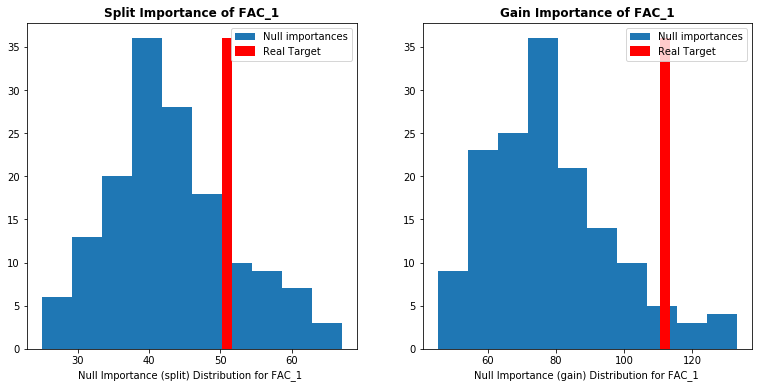

In [75]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='fac_1')

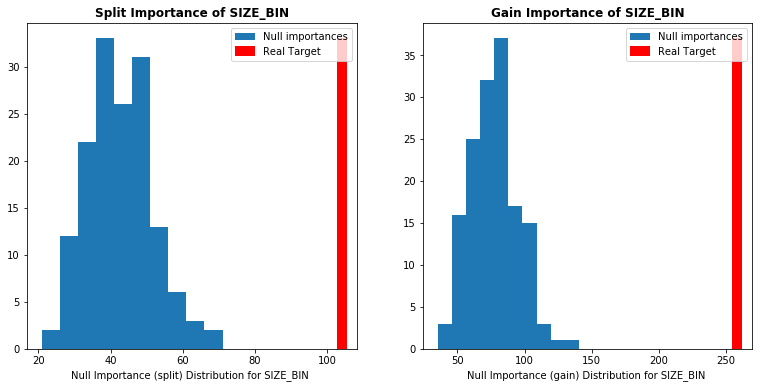

In [76]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='size_bin')

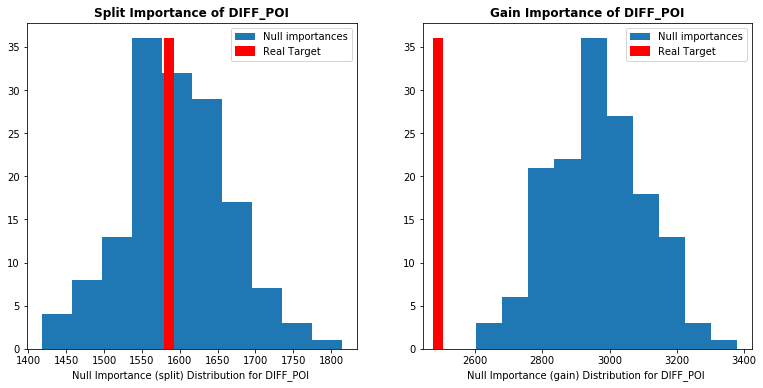

In [77]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='diff_poi')

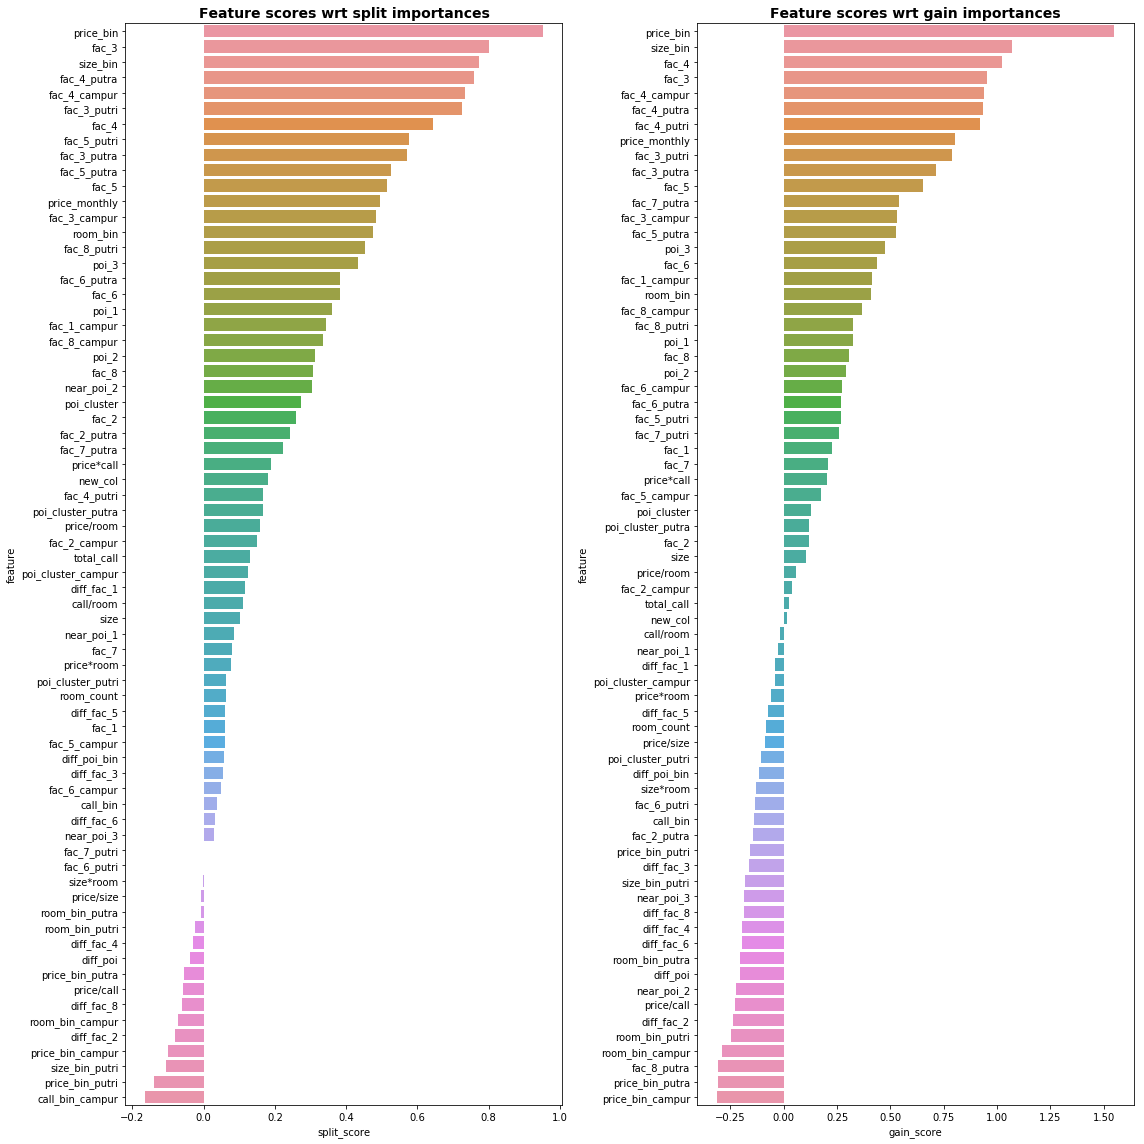

In [78]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

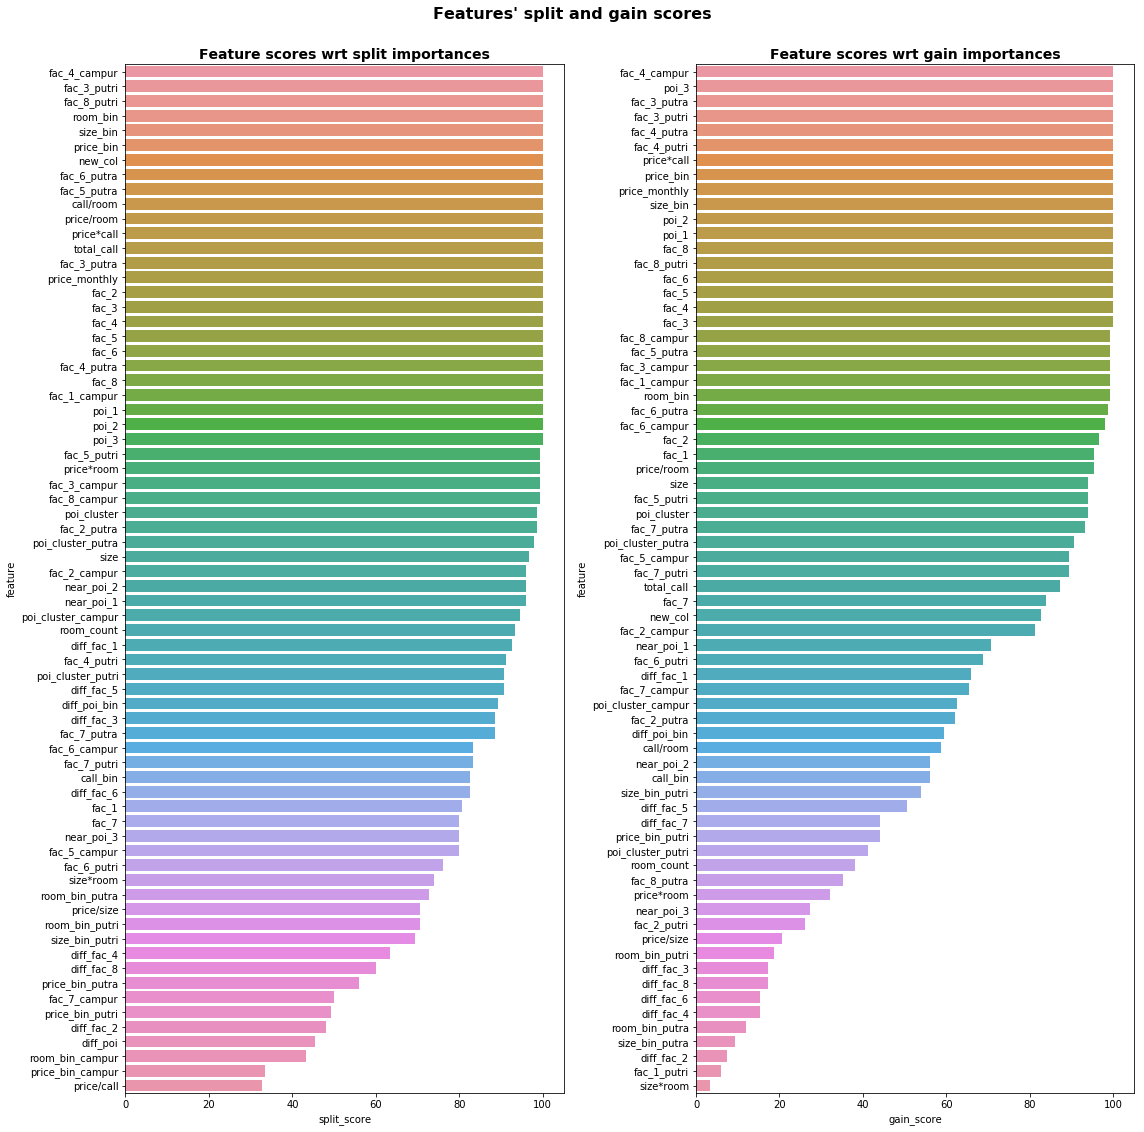

In [79]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [80]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'multiclass',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'multi_logloss'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['multi_logloss-mean'][-1], hist['multi_logloss-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['gender'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['gender'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.823412 +/- 0.034355
	 GAIN  : 0.823412 +/- 0.034355
Results for threshold  10
	 SPLIT : 0.821254 +/- 0.027794
	 GAIN  : 0.815509 +/- 0.031978
Results for threshold  20
	 SPLIT : 0.818824 +/- 0.030963
	 GAIN  : 0.807055 +/- 0.030723
Results for threshold  30
	 SPLIT : 0.817674 +/- 0.033965
	 GAIN  : 0.806705 +/- 0.031088
Results for threshold  40
	 SPLIT : 0.819325 +/- 0.033067
	 GAIN  : 0.812938 +/- 0.028127
Results for threshold  50
	 SPLIT : 0.813281 +/- 0.029829
	 GAIN  : 0.804626 +/- 0.030640
Results for threshold  60
	 SPLIT : 0.814205 +/- 0.031087
	 GAIN  : 0.805158 +/- 0.028999
Results for threshold  70
	 SPLIT : 0.813228 +/- 0.034450
	 GAIN  : 0.801321 +/- 0.030876
Results for threshold  80
	 SPLIT : 0.807343 +/- 0.030505
	 GAIN  : 0.803441 +/- 0.025401
Results for threshold  90
	 SPLIT : 0.803302 +/- 0.033226
	 GAIN  : 0.798356 +/- 0.023188
Results for threshold  95
	 SPLIT : 0.803315 +/- 0.034778
	 GAIN  : 0.791544 +/- 0.025088
Results fo

In [81]:
threshold = 99
gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]

In [82]:
gain_feats

['fac_3',
 'fac_4',
 'fac_5',
 'fac_6',
 'fac_8',
 'poi_1',
 'poi_2',
 'poi_3',
 'price_monthly',
 'price*call',
 'price_bin',
 'size_bin',
 'room_bin',
 'fac_1_campur',
 'fac_3_campur',
 'fac_3_putra',
 'fac_3_putri',
 'fac_4_campur',
 'fac_4_putra',
 'fac_4_putri',
 'fac_5_putra',
 'fac_8_campur',
 'fac_8_putri']

In [83]:
gain_cat_feats

[]